In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from db.models import TableName
from db.db import init_db, read_table
from etl.load.loader import load_raw_data, load_clean_data
from etl.transform.transformer import transform_table
from etl.transform.cleaning import (
    drop_rows_missing_emails,
    drop_emails_with_unmatched_nonalpha,
)
from IPython.display import display, HTML
from scipy.stats import entropy
from db.migrations import run_all_migrations

In [2]:
# Ensure paths for exports exist
os.makedirs("export/stats", exist_ok=True)
os.makedirs("export/plots", exist_ok=True)

This EDA will largely replicate the work done on the LP dataset. Since LP data is the primary focus for this project, the work here will provide context to potential stretch goals that aim to include this data. 

# Initial EDA on raw data
As before, we will do a quick sanity check and exploration of the raw data as it is given. We'll start by loading the data into the database.

In [3]:
# Initialise SQL database
init_db()

# Load the raw data into our SQL database. If it does not
# raise an exception then it should be successful
load_raw_data(TableName.GP)

Tables created successfully.
Read from GP Contact Data
0 upserted, 267454 inserted into GP
Write to gp_raw table complete!
Written 267454 records to GP


Now we can load the data back into a DataFrame and do some quick checks.

In [4]:
# Load into data frames
gp_df = read_table(TableName.GP)
# Print first 5 rows
gp_df.head()

Read GP table from database!


,id,investor,firm_type,title,firm,alternative_name,role,job_title,asset_class,email,...,state,country,zip_code,linkedin,region,address,website,general_email,source_file,time_stamp
0,267454,Yu Yang,Private Equity Firm,Mr.,ZZRY Investment Fund Management,None,None,Chairman,"PE,VC",None,...,Hebei,China,None,None,Asia,"No. 31 Huaxiang Road, Economic and Technologic...",None,wuhaom@enn.com,GP Contact Data,2025-06-20 13:53:51.412764
1,267453,Hui Wu,Investment Company,Mr.,ZZ Capital International,None,None,Chief Operating Officer & Executive Director,"PE,VC",None,...,None,Hong Kong,None,None,Asia,"Room 1204, 12/F, Lee Garden One 33 Hysan Avenu...",None,infohk@zhongjintechology.com,GP Contact Data,2025-06-20 13:53:51.412764
2,267452,Weidong Zhang,Investment Company,Mr.,ZZ Capital International,None,None,Independent Non-Executive Director,"PE,VC",None,...,None,Hong Kong,None,None,Asia,"Room 1204, 12/F, Lee Garden One 33 Hysan Avenu...",None,infohk@zhongjintechology.com,GP Contact Data,2025-06-20 13:53:51.412764
3,267451,Yun Zhang,Investment Company,Ms,ZZ Capital International,None,None,Chief Executive Officer & Executive Director,"PE,VC",None,...,None,Hong Kong,None,None,Asia,"Room 1204, 12/F, Lee Garden One 33 Hysan Avenu...",None,infohk@zhongjintechology.com,GP Contact Data,2025-06-20 13:53:51.412764
4,267450,Nan Bi,Investment Company,Ms,ZZ Capital International,None,None,Vice President,"PE,VC",None,...,None,China,None,www.linkedin.com/in/nan-bi-309b3015/,Asia,"Room 1204, 12/F, Lee Garden One 33 Hysan Avenu...",None,infohk@zhongjintechology.com,GP Contact Data,2025-06-20 13:53:51.412764


Lets take a look at the shape and data types.

In [5]:
gp_df.shape, gp_df.dtypes

((267454, 22),
 id                           int64
 investor                    object
 firm_type                   object
 title                       object
 firm                        object
 alternative_name            object
 role                        object
 job_title                   object
 asset_class                 object
 email                       object
 tel                         object
 city                        object
 state                       object
 country                     object
 zip_code                    object
 linkedin                    object
 region                      object
 address                     object
 website                     object
 general_email               object
 source_file                 object
 time_stamp          datetime64[ns]
 dtype: object)

Looks good. Lets inspect missing values. We'll do this by calculating the percentage of missing values for each column and plot the percentages as a bar graph.

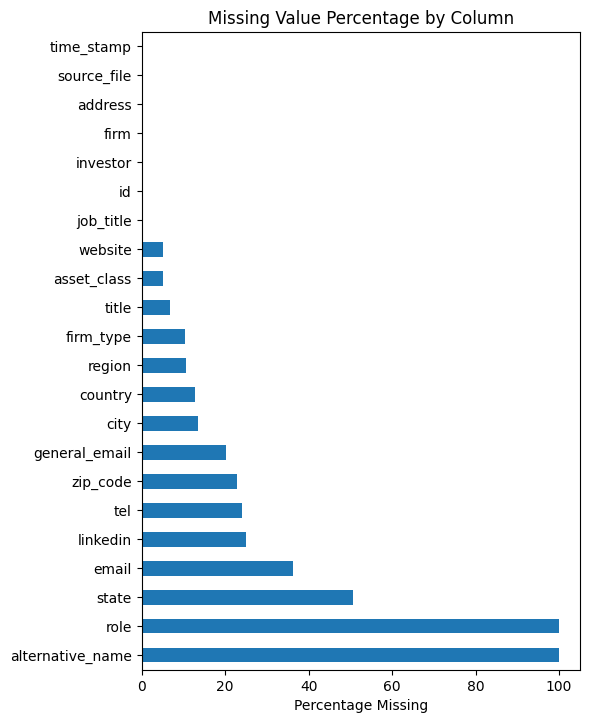

In [6]:
# Find % of missing values per column
missing_pct = gp_df.isna().mean().mul(100).sort_values(ascending=False)

# Quick bar chart to visualise
ax = missing_pct.plot.barh(figsize=(6, max(3, len(missing_pct) / 3)))
plt.title("Missing Value Percentage by Column")
plt.xlabel("Percentage Missing")
plt.tight_layout()

# Export as PNG
plt.savefig("export/plots/missingness_summary_bar_gp.png", dpi=300)

Looks largely the same as our LP data distribution for key fields, with the exception of missing `role` and `alternative_name` fields which don't exist in that dataset.

In [7]:
# Numeric stats: count, mean, etc
stats = gp_df.describe()
stats.to_excel("export/stats/gp_summary_stats_numeric.xlsx")
stats

,id,time_stamp
count,267454.000000,267454
mean,133727.500000,2025-06-20 13:53:51.412764416
min,1.000000,2025-06-20 13:53:51.412764
25%,66864.250000,2025-06-20 13:53:51.412763904
50%,133727.500000,2025-06-20 13:53:51.412763904
75%,200590.750000,2025-06-20 13:53:51.412763904
max,267454.000000,2025-06-20 13:53:51.412764
std,77207.463785,NaN


Only two numeric columns so this is to be expected since ID is auto-incremented and timestamp is the same for all rows.

In [8]:
# Categorical/text: count, unique, etc
stats = gp_df.describe(include="object")
stats.to_excel("export/stats/gp_summary_stats_cat.xlsx")
stats

,investor,firm_type,title,firm,alternative_name,role,job_title,asset_class,email,tel,city,state,country,zip_code,linkedin,region,address,website,general_email,source_file
count,267454,239571,249022,267454,0,0,267191,253688,170748,203264,231157,131911,233516,206423,200604,239229,267454,254016,213221,267454
unique,227167,41,18,40838,0,0,65299,573,166555,70087,3531,670,161,11755,193140,7,38172,36801,29223,1
top,Wei Wang,Private Equity Firm,Mr.,GC&H Investments,NaN,NaN,Partner,PE,peter.chapman@accretion.com.au,+1 212 583 5000,New York,NY,US,10022,www.linkedin.com/in/bragiel/,North America,,http://www.cooley.com,irares@aresmgmt.com,GP Contact Data
freq,23,122801,193967,831,NaN,NaN,18582,79427,2,257,27720,29161,108915,6174,8,125076,6964,831,708,267454


Investor and firm fields have high cardinality, whereas firm type and title do not. Largely scales (from a qualitative glance) the same with the difference in size between LP and GP, nothing out of the ordinary here.

Larger dataset. Bigger skew towards "Private Equity Type" in firm type. "MR" dominates in title field. There is no "ROLE" column in this dataset or alternative names. Email coverage is better here.

Lets highlight unique fields specifically to further illustrate the point. 

In [9]:
# Iterate each column and check there unique and highest repeated values.
for col in gp_df.select_dtypes(include="object").columns:
    print(col, "->", gp_df[col].nunique(), "uniques")
    print(gp_df[col].value_counts().head(5))
    print("---")

investor -> 227167 uniques
investor
Wei Wang              23
                      22
Investor Relations    19
James Kim             18
Lei Wang              17
Name: count, dtype: int64
---
firm_type -> 41 uniques
firm_type
Private Equity Firm               122801
Fund Manager                       44884
Hedge Fund Manager                 39148
Private Equity Firm (Investor)      6537
Fund of Hedge Funds Manager         5682
Name: count, dtype: int64
---
title -> 18 uniques
title
Mr.     193967
Ms       42260
Ms.       5360
Dr.       5359
Miss      1177
Name: count, dtype: int64
---
firm -> 40838 uniques
firm
GC&H Investments            831
Ares Management             654
Kroll                       515
Advent International        405
Apollo Global Management    403
Name: count, dtype: int64
---
alternative_name -> 0 uniques
Series([], Name: count, dtype: int64)
---
role -> 0 uniques
Series([], Name: count, dtype: int64)
---
job_title -> 65299 uniques
job_title
Partner              18

Let's see if there is any corelation for missing columns and rows.

In [10]:
# Compute pairwise missingness
miss_gp = gp_df.isna().astype(int)
corr_gp = miss_gp.corr()
corr_gp["email"].sort_values(ascending=False)

email               1.000000
website             0.152511
title               0.097367
general_email       0.093436
job_title           0.003452
linkedin            0.003368
state              -0.018299
tel                -0.040503
zip_code           -0.054807
asset_class        -0.166574
city               -0.204440
country            -0.218913
region             -0.242694
firm_type          -0.244699
id                       NaN
investor                 NaN
firm                     NaN
alternative_name         NaN
role                     NaN
address                  NaN
source_file              NaN
time_stamp               NaN
Name: email, dtype: float64

Same as with LP records, now its time to investigate duplicates.

In [11]:
# Extract duplicates
dupes_gp = gp_df.duplicated(subset=["investor", "firm"]).sum()
dupes_gp

np.int64(10412)

In [12]:
dup_mask_all = gp_df.duplicated(subset=["investor", "firm"], keep=False)
dupe_rows_all = gp_df[dup_mask_all].sort_values("investor")
dupe_rows_all.head(20)

,id,investor,firm_type,title,firm,alternative_name,role,job_title,asset_class,email,...,state,country,zip_code,linkedin,region,address,website,general_email,source_file,time_stamp
51089,216365,AJ Solimine,None,Mr.,Script Capital,None,None,Managing Partner,"PE,VC",aj@script.capital,...,None,None,None,None,None,548 Market Street Suite 34397,http://www.script.capital/,aj@script.capital,GP Contact Data,2025-06-20 13:53:51.412764
51090,216364,AJ Solimine,Private Equity Firm,Mr.,Script Capital,None,None,Founder & Managing Partner,"PE,VC",aj@122west.vc,...,CA,US,94115,linkedin.com/in/ajsolimine,North America,2852 California Street Apt. 2,https://script.capital/,info@script.capital,GP Contact Data,2025-06-20 13:53:51.412764
222302,45152,Aaditi Tamhankar,None,Ms.,Bluestein Ventures,None,None,Analyst,"PE,VC",aaditi@bluesteinventures.com,...,None,None,None,None,None,415 N LaSalle Drive Suite 700A,http://www.bluesteinventures.com/,andrew@bluesteinventures.com,GP Contact Data,2025-06-20 13:53:51.412764
222306,45148,Aaditi Tamhankar,Private Equity Firm,Ms,Bluestein Ventures,None,None,Analyst,"PE,VC",None,...,IL,US,60654,www.linkedin.com/in/aaditi-tamhankar/,North America,415 North LaSalle Drive Suite 700A,https://www.bluesteinventures.com/,info@bluesteinventures.com,GP Contact Data,2025-06-20 13:53:51.412764
1651,265803,Aakash Kumar,None,Mr.,Z47,None,None,Managing Director,"PE,VC",aakash@z47.com,...,None,None,None,None,None,"601-602, Ceejay House Dr Annie Besant Road, Worli",http://www.z47.com/,info@z47.com,GP Contact Data,2025-06-20 13:53:51.412764
1673,265781,Aakash Kumar,Private Equity Firm,Mr.,Z47,None,None,Managing Director,PE,aakash@matrixpartners.in,...,Karnataka,India,560038,www.linkedin.com/in/kumaraakash/,Asia,"197, 6th Main, 1st Cross HAL 2nd Stage, Indira...",https://www.z47.com/,namaste@z47.com,GP Contact Data,2025-06-20 13:53:51.412764
261041,6413,Aanand Radia,None,Mr.,Achieve Partners,None,None,Managing Director,PE,aanand@achievepartners.com,...,None,None,None,None,None,104 W. 40th St. Suite 1600,http://www.achievepartners.com/,ryan@achievepartners.com,GP Contact Data,2025-06-20 13:53:51.412764
261045,6409,Aanand Radia,Private Equity Firm,Mr.,Achieve Partners,None,None,Managing Director,PE,aanand@achievepartners.com,...,NY,US,10018,www.linkedin.com/in/aanand-radia-368b454/,North America,104 West 40th Street Suite 1600,http://www.achievepartners.com,info@achievepartners.com,GP Contact Data,2025-06-20 13:53:51.412764
245906,21548,Aaquib Nasir,Fund Manager,Mr.,AOF Management,None,None,Senior Analyst,PE,anasir@activeownersfund.com,...,CA,US,90024,None,North America,"10940 Wilshire Boulevard, Suite 1600",https://www.aofmanagement.com/,jflowers@activeownersfund.com,GP Contact Data,2025-06-20 13:53:51.412764
245905,21549,Aaquib Nasir,Fund of Hedge Funds Manager,Mr.,AOF Management,None,None,Senior Analyst,PE,None,...,CA,US,90024,None,North America,10940 Wilshire Boulevard Suite 1600,https://www.aofmanagement.com/,None,GP Contact Data,2025-06-20 13:53:51.412764


We can infer from the top of the duplicates that alot of them are from the same person but working different roles within the company, likely from internal promotions. It would be interesting to see the fields which are still duplicate in `investor` and `firm` but not in `linkedin`.

In [13]:
# Filter duplicates by unique LinkedIns
link_nunique = dupe_rows_all.groupby(["investor", "firm"])["linkedin"].transform(
    lambda s: s.nunique(dropna=True)
)

# Keep only the rows where there’s more than one distinct LinkedIn
mismatch = dupe_rows_all[link_nunique > 1]

# Filter investor names that only appear once
name_counts = mismatch["investor"].value_counts()
keep_names = name_counts[name_counts > 1].index
final = mismatch[mismatch["investor"].isin(keep_names)]

final.sort_values(["investor", "firm"]).head(20)

,id,investor,firm_type,title,firm,alternative_name,role,job_title,asset_class,email,...,state,country,zip_code,linkedin,region,address,website,general_email,source_file,time_stamp
239143,28311,Adesuwa Rhodes,Private Equity Firm,Ms,Aruwa Capital Management,None,None,Founder & Managing Partner,PE,aor@aruwacapital.com,...,None,Nigeria,None,www.linkedin.com/in/adesuwa-okunbo-rhodes-869b...,Africa,14 Adeyemi Lawson Ikoyi,https://www.aruwacapital.com/,info@aruwacapital.com,GP Contact Data,2025-06-20 13:53:51.412764
239134,28320,Adesuwa Rhodes,Private Equity Firm,None,Aruwa Capital Management,None,None,Founder & Managing Partner,PE,None,...,None,Nigeria,None,www.linkedin.com/in/adesuwa-okunbo-rhodes/,Africa,14 Adeyemi Lawson Ikoyi,https://www.aruwacapital.com/,info@aruwacapital.com,GP Contact Data,2025-06-20 13:53:51.412764
221542,45912,Agah Ugur,Private Equity Firm,Mr.,Bogazici Ventures,None,None,Chairman,PE,None,...,None,Turkey,34746,www.linkedin.com/in/agah-ugur-16173020a/?origi...,Europe,"Fenerbahçe, Zühtüpasa Fener Kalamis Caddesi Ti...",http://www.bogaziciventures.com,info@bogaziciventures.com,GP Contact Data,2025-06-20 13:53:51.412764
221544,45910,Agah Ugur,Private Equity Firm,None,Bogazici Ventures,None,None,Chairman,PE,None,...,None,Turkey,34746,www.linkedin.com/in/agah-ugur-16173020a/,Europe,"Fenerbahçe, Zühtüpasa Fener Kalamis Caddesi Ti...",http://www.bogaziciventures.com,info@bogaziciventures.com,GP Contact Data,2025-06-20 13:53:51.412764
70597,196857,Alessandro Esposito,Hedge Fund Manager,Mr.,Portman Square Capital,None,None,Partner & Portfolio Manager,HF,alessandro.esposito@portmansquarecapital.com,...,None,UK,W1H 6AZ,www.linkedin.com/in/alessandro-esposito-cfa-75...,Europe,10 Portman Square,https://www.portmansquarecapital.com/,info@portmansquarecapital.com,GP Contact Data,2025-06-20 13:53:51.412764
70592,196862,Alessandro Esposito,Hedge Fund Manager,None,Portman Square Capital,None,None,"Partner, Portfolio Manager",HF,None,...,None,UK,W1H 6AZ,www.linkedin.com/in/alessandro-esposito-/,Europe,10 Portman Square,https://www.portmansquarecapital.com/,info@portmansquarecapital.com,GP Contact Data,2025-06-20 13:53:51.412764
200685,66769,Amanda Abrams,Private Equity Firm,Ms,Cohen Circle,None,None,Chief Executive Officer,PE,amanda@cohencircle.com,...,NY,US,10019,www.linkedin.com/in/amanda-abrams-86888b9/,North America,3 Columbus Circle 24th Floor,https://cohencircle.com/,info@cohencircle.com,GP Contact Data,2025-06-20 13:53:51.412764
200676,66778,Amanda Abrams,Private Equity Firm,Ms,Cohen Circle,None,None,Chief Executive Officer,PE,None,...,NY,US,10019,www.linkedin.com/in/amanda-abrams1/,North America,3 Columbus Circle 24th Floor,https://cohencircle.com/,info@cohencircle.com,GP Contact Data,2025-06-20 13:53:51.412764
40718,226736,Ana Verde,Private Equity Firm,Ms,Sparkfood,None,None,Head of Finance & Impact,"PE,VC",None,...,None,Portugal,4470-177,www.linkedin.com/in/ana-verde/,Europe,Lugar do Espido Via Norte,http://www.sparkfood.com,sparkfood@sonae.pt,GP Contact Data,2025-06-20 13:53:51.412764
40723,226731,Ana Verde,Private Equity Firm,Miss,Sparkfood,None,None,Head of Finance & Impact,"PE,VC",None,...,None,Portugal,4470-177,www.linkedin.com/in/ana-verde-279a8a18/,Europe,Lugar do Espido Via Norte,http://www.sparkfood.com,sparkfood@sonae.pt,GP Contact Data,2025-06-20 13:53:51.412764


This seems like a good way to prove true duplicates, it will come in useful when we begin cleaning. Let's do some email domain analysis to get an idea of what our data looks like.

In [14]:
# Normalise, split into email doamin and group into pairs
df_pairs = (
    gp_df[["firm", "email"]]
    .dropna(subset=["email"])
    .assign(
        domain=lambda d: d["email"].str.split("@").str[-1].str.lower(),
        firm=lambda d: d["firm"].str.lower(),
    )
    .loc[:, ["domain", "firm"]]
)

# Drop duplicates and print
df_unique = df_pairs.drop_duplicates()
df_unique.to_numpy().tolist()

[['zynik.com', 'zynik capital'],
 ['zynextventures.com', 'zynext ventures'],
 ['zygoteventures.com', 'zygote ventures'],
 ['zx2.io', 'zx squared capital'],
 ['zwickpartners.com', 'zwick investments'],
 ['zweig-dimenna.com', 'zweig-dimenna associates'],
 ['zwcpartners.com', 'zwc ventures'],
 ['zico.co.za', 'zungu investments co'],
 ['zuig.cn', 'zuig investment'],
 ['zuehlke.com', 'zuhlke ventures'],
 ['zufcapital.com', 'zuf capital'],
 ['zubrcapital.com', 'zubr capital'],
 ['zubrcapital.by', 'zubr capital'],
 ['zubr.capital', 'zubr capital'],
 ['zubicapital.com', 'zubilabs'],
 ['zubicapital.com', 'zubi capital'],
 ['zte.com.cn', 'zte capital'],
 ['ztcorporate.com', 'zt corporate'],
 ['ztcorproate.com', 'zt corporate'],
 ['zsfundlp.com', 'zs fund'],
 ['zrosk.com', 'zrosk investment management'],
 ['zouk.com', 'zouk capital llp'],
 ['zouk.com', 'zouk capital'],
 ['zoscales.com', 'zoscales partners'],
 ['zora.vc', 'zora ventures'],
 ['markarch.com', 'zoomworks ventures'],
 ['zonglink.com',

They seem to be all firm name domains. To be sure it would be interesting to see which domains are used across different firms. 

In [15]:
# Count how many distinct firms per domain
domain_firm_counts = df_pairs.groupby("domain")["firm"].nunique()


# Only keep domains where span is larger than 1
multi_firm = domain_firm_counts[domain_firm_counts > 1]

print(multi_firm.shape)
multi_firm.sort_values(ascending=False).to_dict()

(2602,)


{'gmail.com': 99,
 'cvc.com': 21,
 'yahoo.com': 15,
 'hotmail.com': 12,
 'tpg.com': 10,
 'baincapital.com': 9,
 'morganstanley.com': 9,
 'blackrock.com': 8,
 'adventinternational.com': 8,
 'higcapital.com': 7,
 '3i.com': 7,
 'apax.com': 7,
 'nasdaq.com': 7,
 'icgam.com': 7,
 'ubs.com': 7,
 'vertexventures.com': 7,
 'warburgpincus.com': 6,
 '163.com': 6,
 'bregal.com': 6,
 'bnymellon.com': 6,
 'blackstone.com': 6,
 'uobgroup.com': 6,
 'capman.com': 6,
 'samsung.com': 6,
 'macquarie.com': 6,
 'brileyfin.com': 5,
 'harbourvest.com': 5,
 'investcorp.com': 5,
 'franklintempleton.com': 5,
 'eightroads.com': 5,
 'credit-suisse.com': 5,
 'carlyle.com': 5,
 'cmhk.com': 5,
 'gimv.com': 5,
 'apollo.com': 5,
 'aol.com': 5,
 'db.com': 5,
 'bnpparibas.com': 5,
 'starwood.com': 4,
 'stonepoint.com': 4,
 'a-mcapital.com': 4,
 'sig.com': 4,
 'merck.com': 4,
 'miraeasset.com': 4,
 'mercer.com': 4,
 'ifc.org': 4,
 'jpmorgan.com': 4,
 'koreainvestment.com': 4,
 'sbigroup.co.jp': 4,
 'rabobank.com': 4,
 'r

So clearly gmail is generic email domain, probably an individual investor. Whereas other domains seem to be associated with either subtly misspelled firm names or different departments within the same firm.

The next thing to look at is string length distributions to see if we can identify any obvious outliers.

In [16]:
# Compute lengths for each column
length_df = pd.DataFrame(
    {
        "investor_len": gp_df["investor"].dropna().str.len(),
        "email_len": gp_df["email"].dropna().str.len(),
        "firm_len": gp_df["firm"].dropna().str.len(),
    }
)

# Show summary stats
length_df.describe().T

,count,mean,std,min,25%,50%,75%,max
investor_len,267454.0,12.985777,2.963257,1.0,11.0,13.0,15.0,46.0
email_len,170748.0,23.920368,5.633577,7.0,20.0,24.0,28.0,61.0
firm_len,267454.0,18.330494,7.593081,1.0,13.0,17.0,23.0,89.0


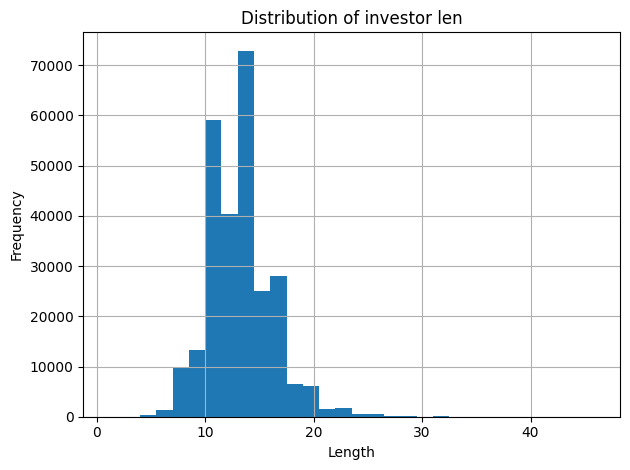

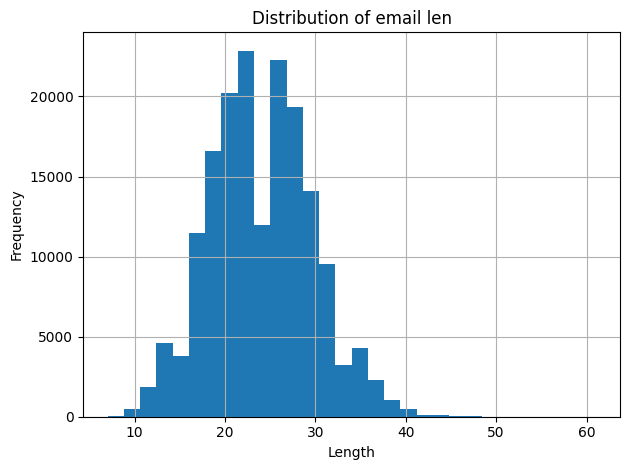

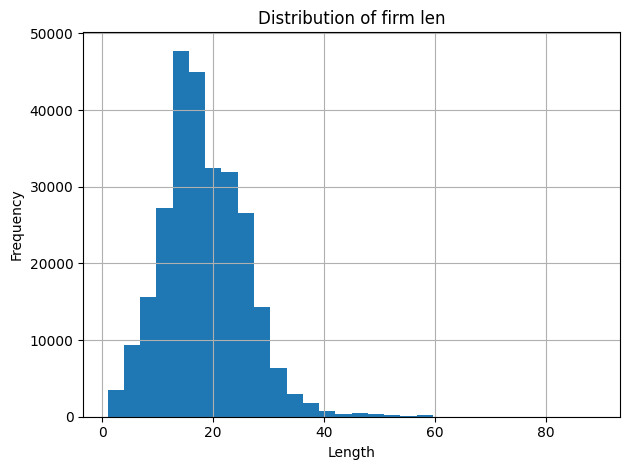

In [17]:
# Plot each distribution
for col in ["investor_len", "email_len", "firm_len"]:
    plt.figure()
    length_df[col].hist(bins=30)
    plt.title(f"Distribution of {col.replace('_', ' ')}")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.tight_layout()
    # Save figure
    out_path = f"export/plots/{col}_hist_gp.png"
    plt.savefig(out_path, dpi=300)
    plt.show()

Very similar distributions to the LP dataset, we can use the same tools to clean and deduplicate.

This will inform the ranges we will use to flag anomalies for manual review.

# Initial Data Cleaning

Now that data cleaning functions have been defined, it is time to do some more EDA to see where we are at before we move onto imputation. We should focus on which fields are missing and which are recoverable. Ultimately the ML model will take investor name and firm name pairs as inputs, so other fields may not be important. However, our initial EDA discovered a lot of missing emails. Our data cleaning process will flag definite duplicates and ambiguous cases for manual review. We'll start by cleaning.

In [18]:
transformed_data_gp = transform_table(TableName.GP)
clean_gp = transformed_data_gp["final_df"]

Read GP table from database!
Table Normalisation Complete!
Table Regex-Cleaning Complete!
Removed 82 bad investor rows!
Table Standardisation Complete!
163 invalid emails lengths found!
96678 missing emails!
47 invalid emails found!
411 invalid LinkedIns found!
66818 missing LinkedIns!
3630 invalid firm lengths found!
0 missing firms!
15412 invalid investor lengths found!
0 missing investors!
24351 missing linkedin and email pairs!
Found 11868 duplicates (excluding retained best row per investor group).
Found 39307 ambiguous duplicates!


Ok, as we already knew, we have a lot of missing emails, with a only a few invalid and potentially invalid emails. We have also identified a decent amount of duplicates and a few ambiguous duplicates for manual inspection.

In [19]:
df = transformed_data_gp["deduplication"]["definite_duplicates"]

# Sort by investor name and email for easier inspection
df_sorted = df.sort_values(by=["investor", "email", "linkedin"])

# View the top rows
print(df_sorted[["id", "investor", "email", "linkedin", "firm", "role"]].head(50))

            id               investor                                email  \
240277   27177          a. bilal noor               bnoor@arlingtoncap.com   
237210   30244    a. christian remmel          cremmel@aterianpartners.com   
222510   44944         a. david kocen                adkocen@bluehenge.com   
265593    1861           aakash desai                                 None   
188676   78778           aakash kumar                                 None   
222714   44740           aakash patel           aakash@bluewolfcapital.com   
34893   232561        aalap mahadevia                                 None   
173002   94452           aamir rehman                                 None   
261045    6409           aanand radia           aanand@achievepartners.com   
261041    6413           aanand radia           aanand@achievepartners.com   
93546   173908             aaron bock                                 None   
74924   192530   aaron christopherson  aaron.christopherson@prud

This looks good, solid duplicates found and dealt with. Lets take a look at the ambiguous cases to see if there are any trends to be found.

In [20]:
ambiguous_duplicates_df = transformed_data_gp["deduplication"]["ambiguous_duplicates"]

# Sort by investor name and email for easier inspection
ambiguous_duplicates_df = ambiguous_duplicates_df.sort_values(
    by=["investor", "email", "linkedin"]
)

# Select relevant columns and top 50 rows
top50 = ambiguous_duplicates_df[
    ["id", "investor", "email", "linkedin", "firm", "role"]
].head(50)

# Save to Excel
top50.to_excel("export/stats/ambiguous_duplicates_top50_gp.xlsx", index=False)

print(ambiguous_duplicates_df.shape)
top50

(39307, 22)


,id,investor,email,linkedin,firm,role
77271,190183,aadil chitalwala,aadil@peakventures.in,None,peak sustainability ventures,None
77254,190200,aadil chitalwala,None,www.linkedin.com/in/aadil-chitalwala/,peak venture partners,None
159354,108100,aakanksha sharma,aakanksha@venturehighway.vc,www.linkedin.com/in/aakanksha-sharma-19156b23/,general catalyst india,None
159359,108095,aakanksha sharma,asharma@generalcatalyst.com,None,general catalyst,None
169060,98394,aakash butala,aakash.butala@rothschildandco.com,www.linkedin.com/in/aakash-butala-1b26b012/,five arrows,None
56748,210706,aakash butala,None,www.linkedin.com/in/aakash-butala-1b26b012,rothschild merchant banking,None
55339,212115,aakash desai,adesai@rvcapital.com,www.linkedin.com/in/aakash-desai-0952461b/,rv capital management,None
265583,1871,aakash desai,None,www.linkedin.com/in/aakash-desai-044bb14/,360 one asset,None
265620,1834,aakash desai,None,None,360 one,None
239110,28344,aakash jain,aakash.jain@arvog.com,www.linkedin.com/in/aakash-jain-4b7a6261/,arvog,None


From a quick precursory look, we can see there are a few cases where people with the same name have different email domains. Possibly the same person in a different position or two different people with the same name. There are also a few cases of the same name but one instance with a missing email, once again could be the same person or two different people with the same name. Lets look at some more statistics. 

In [21]:
# How many investors have >2 entries
ambiguous_counts = ambiguous_duplicates_df["investor"].value_counts()
print(ambiguous_counts.describe())
print(ambiguous_counts[ambiguous_counts > 2].head(10))

count    16188.000000
mean         2.428157
std          1.149735
min          2.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         23.000000
Name: count, dtype: float64
investor
wei wang              23
investor relations    21
james kim             18
yang liu              17
david lee             17
wei li                17
lei wang              17
wei zhang             16
michael lee           16
david smith           15
Name: count, dtype: int64


High frequency names are probably false positives. There are also a lot of ambiguous investor duplicates with most of them occurring twice. Only a handful go up to 10+ entries, these should be the priority for manual inspection.

In [22]:
# View all entries for a specific investor (e.g. top ambiguous case)
investor = ambiguous_counts.idxmax()
print(
    ambiguous_duplicates_df[ambiguous_duplicates_df["investor"] == investor][
        ["id", "email", "linkedin", "firm", "role"]
    ]
)

            id                           email  \
166240  101214                 wangw@foicl.com   
143237  124217          wangwei@hongdaocap.com   
42837   224617            wangwei@soaringx.com   
130692  136762       wangwei@yunjincapital.com   
221548   45906      wei.wang@bogayacapital.com   
205402   62052        wei.wang@crcicapital.com   
69230   198224  wei.wang@primavera-capital.com   
41261   226193            ww@sourcecodecap.com   
237830   29624                            None   
20898   246556                            None   
44925   222529                            None   
59470   207984                            None   
65708   201746                            None   
66044   201410                            None   
74383   193071                            None   
98925   168529                            None   
113166  154288                            None   
113171  154283                            None   
129381  138073                            None   


Here is an example of a false positive. 

Let's take a look at our missing values to see if we can better inform our imputation strategy. 

In [23]:
# Check null percentage per column
missing_summary = clean_gp.isnull().mean().sort_values(ascending=False)
print(missing_summary[missing_summary > 0])

alternative_name    1.000000
role                1.000000
state               0.499211
email               0.350236
linkedin            0.218671
tel                 0.214064
general_email       0.201603
zip_code            0.196030
city                0.106940
country             0.098160
region              0.076999
firm_type           0.075727
title               0.074474
website             0.047156
asset_class         0.028789
job_title           0.000874
dtype: float64


Fields like `state`, `city`, `zip_code`, `region`, `title` and `role` could be useful for filtering duplicates and have relatively low missing rates. These fields could reasonably inferred from the firm name. 

The priority here is clearly the `email` is the priority, potentially we could fallback to general email or even the LinkedIn profile. Lets see how often `email`, `linkedin` and `general_email` are missing together.

In [24]:
# Check email and general email missingness
email_missing_general_present = (
    clean_gp["email"].isnull() & clean_gp["general_email"].notnull()
)
email_present_general_missing = (
    clean_gp["email"].notnull() & clean_gp["general_email"].isnull()
)
both_missing = clean_gp["email"].isnull() & clean_gp["general_email"].isnull()

# Check email and linkedin missingness
email_missing_linkedin_present = (
    clean_gp["email"].isnull() & clean_gp["linkedin"].notnull()
)
email_present_linkedin_missing = (
    clean_gp["email"].notnull() & clean_gp["linkedin"].isnull()
)
both_missing_linkedin = clean_gp["email"].isnull() & clean_gp["linkedin"].isnull()

# Print summary counts
print("Email missing & General Email present:", email_missing_general_present.sum())
print("Email present & General Email missing:", email_present_general_missing.sum())
print("Both Email and General Email missing:", both_missing.sum())
print("Email missing & LinkedIn present:", email_missing_linkedin_present.sum())
print("Email present & LinkedIn missing:", email_present_linkedin_missing.sum())
print("Both Email and LinkedIn missing:", both_missing_linkedin.sum())

Email missing & General Email present: 56974
Email present & General Email missing: 24840
Both Email and General Email missing: 18746
Email missing & LinkedIn present: 57005
Email present & LinkedIn missing: 28561
Both Email and LinkedIn missing: 18715


So clearly there is oppurtunity to recover missing emails from LinkedIn and maybe even general email. Although using the general email as fallback could pollute the dataset as we miss out on the syntactic structure of first and last name in the email construction.

Lets see if there is any corelation between the missing values.

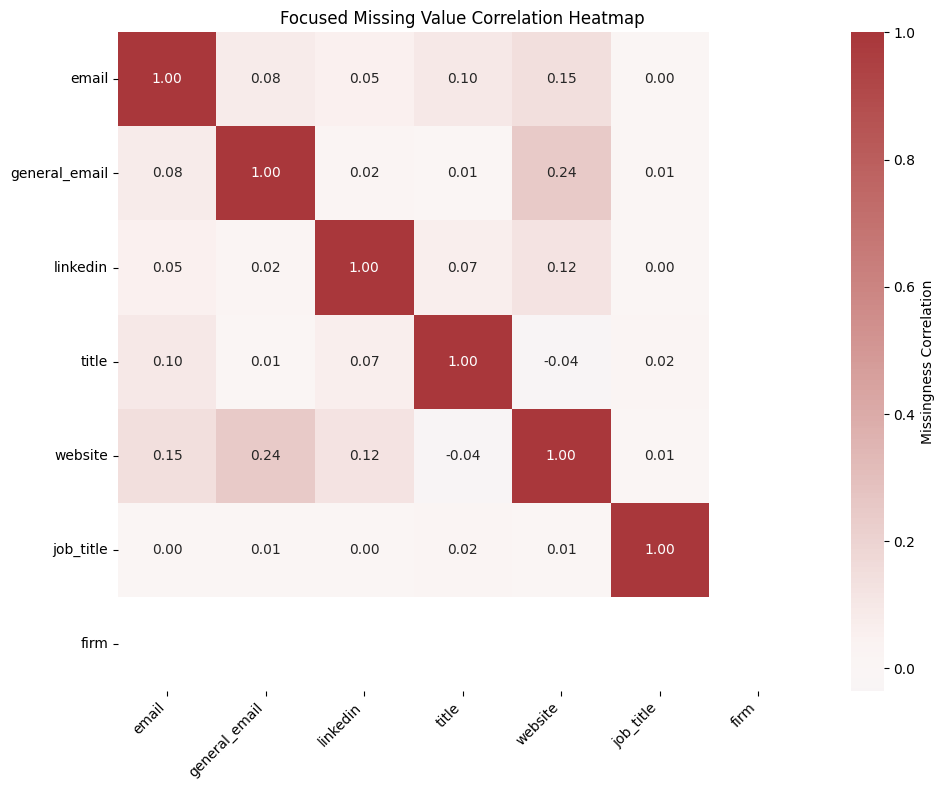

In [25]:
# Correlation between relevant fields
fields = ["email", "general_email", "linkedin", "title", "website", "job_title", "firm"]

# Filter and create massiness matrix
missing_corr = clean_gp[fields].isnull().astype(int).corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    missing_corr,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    cbar_kws={"label": "Missingness Correlation"},
)
plt.title("Focused Missing Value Correlation Heatmap")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Save
plt.savefig("export/plots/missingness_correlation_heatmap_gp.png", dpi=300)

Similar to the LP case, there isn't much of a corelation in missingness. Will use same tactics as LP case for duplication and fallbacks.

In [26]:
clean_gp = drop_rows_missing_emails(clean_gp)
clean_gp.shape

(140477, 22)

First thing to do is look at our flagged invalid emails. Theres only a few so we can take a look here.

In [27]:
invalid_ids = transformed_data_gp["validation"]["invalid_email"]
# Pull those rows from the main clean dataset
invalid_emails_df = clean_gp[clean_gp["id"].isin(invalid_ids)].copy()

display(
    HTML(
        invalid_emails_df[["investor", "email"]]
        .to_html()
        .replace("<table", '<div style="max-height:300px;overflow:auto;"><table')
        .replace("</table>", "</table></div>")
    )
)

,investor,email
99,jose nistal,josé@zubicapital.com
7770,guillaume marquet de vasselot,guillaume.marquetdevasselot@weinbergcapital.com
10664,anna pölönen,anna.pölönen@voimaventures.com
13060,sari weckström,sari.weckstrom@­versocapital.com
13063,mika suomela,mika.suomela@­versocapital.com
13066,philip saxby,philip.saxby@­versocapital.com
13067,kristian ukonaho,kristian.ukonaho@­versocapital.com
15316,maria dupré,maria.duprè@vaminvestments.com
23978,charles goodwin,cg@to.vc
23979,howard-yana shapiro,hys@to.vc


These largely are flagged for being outside the expected character range. Largely the same as before, except we have cases here with clearly malformed emails (? and no @ symbols present), our existing cleaning utilities will handle this.

In [28]:
print(clean_gp.shape)
clean_gp = drop_emails_with_unmatched_nonalpha(clean_gp)
print(clean_gp.shape)

(140477, 22)
(140456, 22)


Lets take a look at our ambiguous duplicates. Theres a lot of them so lets try to group them to filter into smaller groups. We'll try same name and role, and same name and firm.

In [29]:
# Clean records
ambiguous_duplicates_df = drop_rows_missing_emails(ambiguous_duplicates_df)
ambiguous_duplicates_df = drop_emails_with_unmatched_nonalpha(ambiguous_duplicates_df)

# Group by role
grouped_role = ambiguous_duplicates_df.groupby(["investor", "job_title"])
group_sizes = (
    grouped_role.size().reset_index(name="count").sort_values("count", ascending=False)
)
display(group_sizes.head())

,investor,job_title,count
8430,investor relations,investor relations,10
14823,michael chan,managing director,3
536,alessandro benetton,founding managing partner,3
7787,greg williams,managing director,3
2604,blake miller,vice president,3


Ok these are likely have some duplicates within them. Lets see what the diversity of firms are in the group.

In [30]:
firm_diversity = (
    grouped_role["firm"]
    .nunique()
    .reset_index(name="unique_firms")
    .sort_values("unique_firms", ascending=False)
)

# How many are spread across multiple firms?
num_multi_firm = (firm_diversity["unique_firms"] > 1).sum()
print(f"{num_multi_firm} of {firm_diversity.shape[0]} groups span multiple firms")

1113 of 22934 groups span multiple firms


Seems like we could be looking at the same person duplicated at different companies during different points of there career. Lets see the stats for unique firm per group.

In [31]:
group_stats = group_sizes.merge(firm_diversity, on=["investor", "job_title"])
top_20_carreer_move = group_stats.sort_values("unique_firms", ascending=False).head(20)

# Export top 20 rows sorted by unique firm count
top_20_carreer_move.to_excel(
    "export/stats/career_move_stats_top20_gp.xlsx", index=False
)

display(top_20_carreer_move)

,investor,job_title,count,unique_firms
0,investor relations,investor relations,10,10
30,david fischer,partner,3,3
28,general contact,general contact,3,3
27,michael chen,managing director,3,3
25,ed lascelles,partner,3,3
24,mark mccall,managing director,3,3
23,michael johnson,managing director,3,3
3,greg williams,managing director,3,3
2,alessandro benetton,founding managing partner,3,3
4,blake miller,vice president,3,3


Ok this refines things. Lets take a look at the role spread.

In [32]:
firm_spread = grouped_role["firm"].nunique().reset_index(name="unique_firms")
group_stats = group_sizes.merge(firm_spread, on=["investor", "job_title"])
# Get Row Ids
group_ids = grouped_role["id"].apply(list).reset_index(name="ids")
# Merge for traceability
group_stats = group_stats.merge(group_ids, on=["investor", "job_title"])
display(group_stats.head())

,investor,job_title,count,unique_firms,ids
0,investor relations,investor relations,10,10,"[164084, 130568, 109068, 146532, 156035, 20293..."
1,michael chan,managing director,3,2,"[230949, 1993, 230983]"
2,alessandro benetton,founding managing partner,3,3,"[1304, 1367, 1337]"
3,greg williams,managing director,3,3,"[5751, 75773, 5706]"
4,blake miller,vice president,3,3,"[83093, 89410, 258474]"


So clearly there is a few instances during at the top of the group frame that may be false positives. Or at least include false positives. It also seems that the unique firm distribution has a long tail.

The matching count and unique firm count strongly indicate duplicates of people that have left a company to somewhere new. I am now rethinking manual deduplication, instead this grouping provides valuable data for our model. Since our data works of `investor`-`firm` pairs, the same person across different companies is valuable training data. We will include this grouping and merge it into our clean database.

In [33]:
# Find career moves in ambiguous set
career_moves = group_stats[group_stats["count"] == group_stats["unique_firms"]]
# Get the IDs for those groups
career_move_ids = career_moves["ids"].explode().astype(int)
# Pull the matching rows from ambiguous_duplicates_df
career_move_rows = ambiguous_duplicates_df[
    ambiguous_duplicates_df["id"].isin(career_move_ids)
]
# Merge these into clean_gp (stack them together)
clean_gp_extended = pd.concat([clean_gp, career_move_rows], ignore_index=True)
clean_gp_extended.shape

(164419, 22)

This looks like our final clean GP dataset. Time to write it back to the database.

In [34]:
clean_gp_extended.shape[0]

164419

In [35]:
load_clean_data(TableName.GP_CLEAN, clean_gp_extended)

164419 upserted, 0 inserted into GP_CLEAN
Wrote 164419 rows to GP_CLEAN
164419 upserted, 0 inserted into COMBINED_CLEAN
Also wrote 164419 rows to COMBINED_CLEAN


# Post Cleaning EDA
Below we will conduct our final round of EDA on the cleaned data. We will do some Firm-to-Domain analysis which should give valuable context to our template distribution analysis we will do in the next phase. We'll also look into key field cardinality and some basic domain analysis.

Lets start with plotting firm and domain counts.

Read GP_CLEAN table from database!
(2426,)


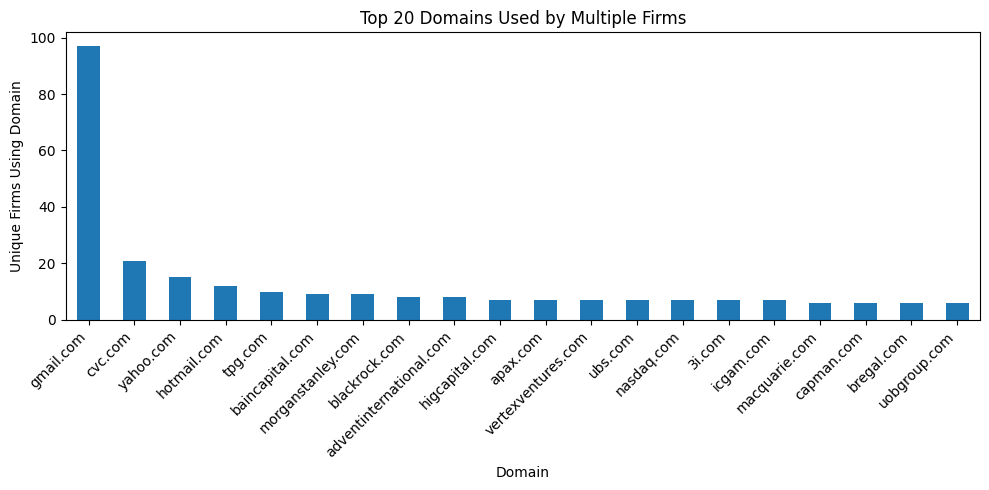

In [36]:
# Load the clean GP data
gp_df = read_table(TableName.GP_CLEAN)
# Extract domain and count firms per domain
gp_df["domain"] = gp_df["email"].str.extract("@(.*)$")[0].str.lower()
domain_firm_counts = (
    gp_df.groupby("domain")["firm"].nunique().sort_values(ascending=False)
)

# Filter to only domains used by >1 firm (for clarity)
shared_domains = domain_firm_counts[domain_firm_counts > 1]
print(shared_domains.shape)

plt.figure(figsize=(10, 5))
shared_domains.head(20).plot(kind="bar")
plt.title("Top 20 Domains Used by Multiple Firms")
plt.xlabel("Domain")
plt.ylabel("Unique Firms Using Domain")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Save the figure
plt.savefig("export/plots/top_20_shared_domains_gp.png", dpi=300)

plt.show()

So clearly "gmail.com" is generic email probably used by an individual investor. But other cases of domains used by 10-30 firms are a bit more ambiguous - could be holding companies or multi brand orgs, or it could be misattributed firms names.

Let's look at a specific example.

In [37]:
gp_df[gp_df["domain"] == "morganstanley.com"][
    ["investor", "firm", "email", "website"]
].head(20)

,investor,firm,email,website
62200,wei zhou,morgan stanley private equity asia,wei.zhou@morganstanley.com,www.morganstanley.com
62201,cynthia xu,morgan stanley private equity asia,cynthia.xu@morganstanley.com,www.morganstanley.com
62202,anni hu,morgan stanley private equity asia,anni.hu@morganstanley.com,www.morganstanley.com
62203,mike wilson,morgan stanley private equity asia,m.wilson@morganstanley.com,www.morganstanley.com
62204,tao sun,morgan stanley private equity asia,tao.sun@morganstanley.com,www.morganstanley.com
62205,arjun saigal,morgan stanley private equity asia,arjun.saigal@morganstanley.com,www.morganstanley.com
62206,ling wei ong,morgan stanley private equity asia,ling.wei.ong@morganstanley.com,www.morganstanley.com
62207,sofia knightley,morgan stanley private equity asia,sofia.nala.knightley@morganstanley.com,www.morganstanley.com
62208,jun xu,morgan stanley private equity asia,jun.xu@morganstanley.com,www.morganstanley.com
62209,michael chung,morgan stanley private equity asia,michael.chung@morganstanley.com,www.morganstanley.com


So it seems like despite the shared domains coming from different firms, they generally follow the same template structure. However, it represents a potential edge case where they don't. In such a case, providing a domain name to the predictor could be unreliable or even pollute the dataset, since the domain could be used by multiple firms each using different email templates. This could lead to overgeneralization in some cases.

To combat this I think adding a boolean `shared_domain` flag to the clean data could help us disambiguate by giving more weight to the `firm` name when the flag is true and lowering confidence thresholds such that we more aggressively rely on fallbacks. We could even use a secondary classifier if the model is still unsure.

In [38]:
gp_df["is_shared_infra"] = gp_df["domain"].isin(shared_domains.index)

Lets do the same for domains per firm.

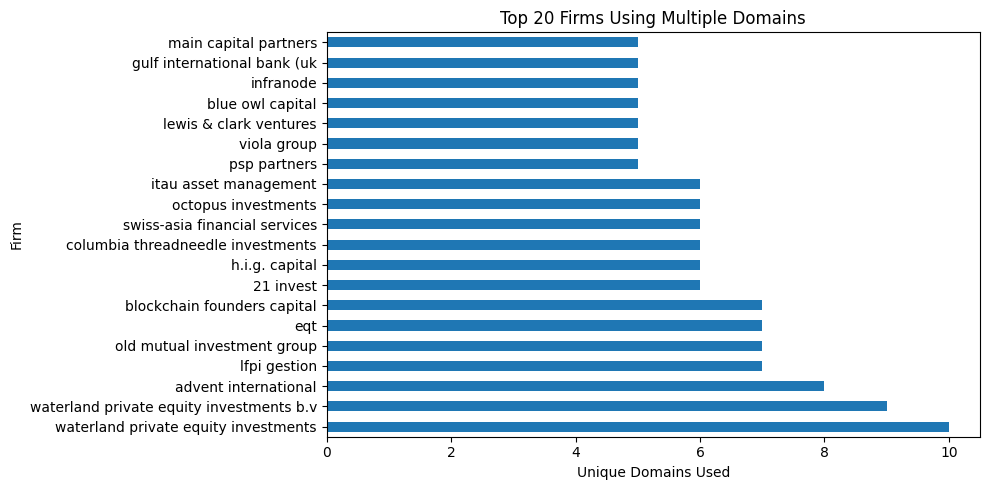

In [39]:
# Count domains per firm
firm_domain_counts = (
    gp_df.groupby("firm")["domain"].nunique().sort_values(ascending=False)
)

# Filter to firms using >1 domain
multi_domain_firms = firm_domain_counts[firm_domain_counts > 1]

plt.figure(figsize=(10, 5))
multi_domain_firms.head(20).plot(kind="barh")
plt.title("Top 20 Firms Using Multiple Domains")
plt.xlabel("Unique Domains Used")
plt.ylabel("Firm")
plt.tight_layout()

# Save the figure
plt.savefig("export/plots/top_20_shared_firms_gp.png", dpi=300)

plt.show()

The chart shows a complementary story, where multiple domains are used with the same firm. This could be from subsidiaries or regional branches, let's look at a specific case.

In [40]:
# Subset for firm
df = gp_df[gp_df["firm"].str.lower() == "21 invest"].copy()
# Extract domain
df["domain"] = df["email"].str.extract(r"@(.+)$")[0].str.lower()
# Drop duplicates based on domain
unique_domains_df = df.drop_duplicates(subset="domain")

unique_domains_df[["investor", "firm", "email", "website"]].head(20)

,investor,firm,email,website
163754,massimo galli,21 invest,m.galli@21invest.com,www.21invest.com/
163759,dino furlan,21 invest,d.furlan@21investimenti.com,www.21invest.com/
163761,alessandro benetton,21 invest,a.benetton@21investimenti.it,www.21invest.com/
163762,hadrien jourdan,21 invest,h.jourdan@21centralepartners.com,www.21invest.com/
163770,dominik biegaj,21 invest,d.biegaj@21concordia.com,www.21invest.com/
163772,françois barbier,21 invest,f.barbier@21investfrance.com,www.21invest.com/


Using the same logic in the reverse case, we should incorporate a similar flag to inform our model of these cases.

In [41]:
gp_df["firm_is_multi_domain"] = gp_df["firm"].isin(multi_domain_firms.index)

Lets inspect our `firm` and `domain` cardinality. 

In [42]:
print("Unique firms:", gp_df["firm"].nunique())
print("Unique domains:", gp_df["domain"].nunique())
print("Top domains:\n", gp_df["domain"].value_counts().head(10))
print("Top firms:\n", gp_df["firm"].value_counts().head(10))

Unique firms: 28022
Unique domains: 28354
Top domains:
 domain
cooley.com           826
kroll.com            506
cvc.com              419
aresmgmt.com         338
blackstone.com       322
apollo.com           292
cohenco.com          281
partnersgroup.com    273
eqtpartners.com      265
nb.com               256
Name: count, dtype: int64
Top firms:
 firm
gc&h investments            826
kroll                       510
ares management             306
apollo global management    299
cvc                         293
cohen & company             290
eqt                         264
teneo ventures              254
oaktree capital             248
ardian                      228
Name: count, dtype: int64


So it seems like we have pretty consistent domain-firm mapping for most cases, this means our secondary pattern miner (trained on domain-firm templates) should successfully capture the majority of cases. It also seems like most firms use one domain which should indicate a dwindling effect by the edge cases.

It would be interesting to see how consistent each domain is in terms of email local-part structure.

In [43]:
# Extract domain and local-part
gp_df["local_part"] = gp_df["email"].str.extract(r"^([^@]+)")[0]

# Compute entropy per domain
domain_entropy = (
    gp_df.dropna(subset=["local_part", "domain"])
    .groupby("domain")["local_part"]
    .apply(lambda x: entropy(x.value_counts(normalize=True)))
    .sort_values(ascending=False)
)

# See how consistent top domains are
domain_entropy.loc[
    ["cooley.com", "kroll.com", "cvc.com", "aresmgmt.com", "blackstone.com"]
]

domain
cooley.com        6.716595
kroll.com         6.226537
cvc.com           6.037871
aresmgmt.com      5.823046
blackstone.com    5.774552
Name: local_part, dtype: float64

This concludes the GP dataset EDA. Results largely align with LP dataset, with nothing really else to action as a result. Will do the same for the combined set.

In [44]:
# Migrate to new schema
run_all_migrations()
# Drop superfluous columns
gp_df.drop(columns=["local_part", "domain"], inplace=True)

# Write back to table
load_clean_data(TableName.GP_CLEAN, gp_df)

Column 'is_shared_infra' already exists in 'lp_clean'.
Column 'firm_is_multi_domain' already exists in 'lp_clean'.
Column 'is_shared_infra' already exists in 'gp_clean'.
Column 'firm_is_multi_domain' already exists in 'gp_clean'.
Column 'is_shared_infra' already exists in 'combined_clean'.
Column 'firm_is_multi_domain' already exists in 'combined_clean'.
164419 upserted, 0 inserted into GP_CLEAN
Wrote 164419 rows to GP_CLEAN
164419 upserted, 0 inserted into COMBINED_CLEAN
Also wrote 164419 rows to COMBINED_CLEAN
